In [56]:
# Imports
import geopandas as gpd
import numpy as np
import pandas as pd
import os 
import requests
import json
import datetime
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import geopandas as gpd
from shapely.geometry import Point

### Purple Air

In [57]:
df_purple = pd.read_csv("../static/data/slc_daily_pm2.5_pm10_2016to2024.csv")
df_purple = df_purple.sort_values(['date'], ascending = False)

In [58]:
df_purple = df_purple[['sensor_id','latitude','longitude','date','altitude','pm2.5_atm','pm10.0_atm']]
df_purple.rename(columns = {'pm2.5_atm':'pm2','pm10.0_atm':'pm10'},inplace=True)
df_purple['date'] = pd.to_datetime(df_purple['date'], format='%m/%d/%y')
df_purple['month'] = df_purple['date'].dt.month
df_purple.head()


,sensor_id,latitude,longitude,date,altitude,pm2,pm10,month
232809,83563,41.153950,-111.937020,2023-09-09,4806,2.0930,2.3085,9
243366,122011,40.639800,-111.822510,2023-09-09,4499,0.4095,0.5130,9
241621,114467,41.063160,-111.903320,2023-09-09,5104,0.1460,0.2130,9
225969,44157,40.574078,-111.958800,2023-09-09,4533,10.7160,12.9255,9
217892,30967,41.066500,-111.912445,2023-09-09,4774,3.4305,3.9045,9


In [59]:
# Convert df_purple to a GeoDataFrame
gdf_purple = gpd.GeoDataFrame(
    df_purple, 
    geometry=gpd.points_from_xy(df_purple.longitude, df_purple.latitude),
    crs="EPSG:4326" # Assuming the coordinates are in WGS84
)

In [60]:
# Load Dataset for Join
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')

In [61]:
# Perform a spatial join
joined_gdf = gpd.sjoin(gdf_purple, geojson_gdf, how="inner", op="within")

/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [62]:
joined_gdf.columns

Index(['sensor_id', 'latitude', 'longitude', 'date', 'altitude', 'pm2', 'pm10',
       'month', 'geometry', 'index_right', 'OBJECTID', 'GEOID', 'Source',
       'geoname', 'Stusab', 'Countyname', 'State', 'County', 'Tract', 'BLKGRP',
       'Low', 'Lowmod', 'Lmmi', 'Lowmoduniv', 'Lowmod_pct', 'uclowmod',
       'ucLowmod_p', 'MOE_LOWMOD_PCT', 'MOE_UCLOWMOD_PCT', 'Shape__Area',
       'Shape__Length', 'category'],
      dtype='object')

In [63]:
joined_gdf = joined_gdf[['sensor_id','latitude','longitude','date','Countyname','category','month','pm2','pm10']]
joined_gdf = joined_gdf.rename(columns = {'Countyname':'county'})

In [64]:
avg_pm = joined_gdf.groupby(['county', 'date'])[['pm2', 'pm10']].mean().reset_index()
avg_pm.columns = ['county', 'date', 'avg_pm2', 'avg_pm10']
avg_pm

,county,date,avg_pm2,avg_pm10
0,Davis County,2017-11-18,59.099000,83.647500
1,Davis County,2017-12-14,55.391500,82.216500
2,Davis County,2017-12-17,3.371500,3.737000
3,Davis County,2017-12-18,14.419500,15.746000
4,Davis County,2017-12-19,18.354000,20.184500
...,...,...,...,...
7787,Weber County,2024-03-04,133.610400,134.006167
7788,Weber County,2024-03-05,127.340900,127.750733
7789,Weber County,2024-03-06,117.259433,117.676000
7790,Weber County,2024-03-07,120.556000,121.088933


In [65]:
# Ensure that the 'date' column in both DataFrames are of the same type, preferably datetime64
joined_gdf['date'] = pd.to_datetime(joined_gdf['date'])
avg_pm['date'] = pd.to_datetime(avg_pm['date'])

# Merging the average values back to the original GeoDataFrame
joined_gdf_finalx = joined_gdf.merge(avg_pm, on=['county', 'date'], how='left')


In [66]:
joined_gdf_finalx.head()

,sensor_id,latitude,longitude,date,county,category,month,pm2,pm10,avg_pm2,avg_pm10
0,83563,41.153950,-111.937020,2023-09-09,Weber County,green,9,2.0930,2.3085,110.958733,111.263967
1,122011,40.639800,-111.822510,2023-09-09,Salt Lake County,blue,9,0.4095,0.5130,141.612708,141.949592
2,114467,41.063160,-111.903320,2023-09-09,Davis County,blue,9,0.1460,0.2130,78.739573,79.045115
3,44157,40.574078,-111.958800,2023-09-09,Salt Lake County,blue,9,10.7160,12.9255,141.612708,141.949592
4,30967,41.066500,-111.912445,2023-09-09,Davis County,blue,9,3.4305,3.9045,78.739573,79.045115


In [67]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.date >= '2021-01-01']

In [68]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Placeholder for results
nearest_pm2_5 = []

for date, group in joined_gdf_finalx.groupby('date'):
    # Extract coordinates and pm2.5 values
    coords = group[['latitude', 'longitude']].values
    pm2_5_values = group['pm2'].values
    
    # NearestNeighbors model, looking for the 2 closest neighbors
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # The nearest sensor (excluding itself) is at index 1 (0 is the sensor itself)
    nearest_indices = indices[:, 1]
    
    # Retrieve the pm2.5 values of the nearest sensors
    nearest_pm2_5_values = pm2_5_values[nearest_indices]
    
    # Append to our placeholder
    nearest_pm2_5.extend(nearest_pm2_5_values)

# Add the nearest sensor's pm2.5 value as a new column in the original DataFrame
joined_gdf_finalx['nearest_pm2_5'] = nearest_pm2_5

In [69]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Placeholder for results
nearest_pm10 = []

for date, group in joined_gdf_finalx.groupby('date'):
    # Extract coordinates and pm2.5 values
    coords = group[['latitude', 'longitude']].values
    pm10_values = group['pm10'].values
    
    # NearestNeighbors model, looking for the 2 closest neighbors
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # The nearest sensor (excluding itself) is at index 1 (0 is the sensor itself)
    nearest_indices = indices[:, 1]
    
    # Retrieve the pm2.5 values of the nearest sensors
    nearest_pm10_values = pm10_values[nearest_indices]
    
    # Append to our placeholder
    nearest_pm10.extend(nearest_pm10_values)

# Add the nearest sensor's pm2.5 value as a new column in the original DataFrame
joined_gdf_finalx['nearest_pm10'] = nearest_pm10

### Encode Categories

In [70]:
# 
category_map = {'red':1,'orange':2,'green':3,'blue':4}
county_map = {'Salt Lake County':1,'Weber County':2,'Davis County':3}
df = joined_gdf_finalx
df['county_encoded'] = df['county'].map(county_map)
df['category_encoded'] = df['category'].map(category_map)

### Prep Data

In [71]:
df = df.loc[df.pm2<125]
df = df.loc[df.pm10<125]
df
#df = df.loc[df.avg_pm2<35]

,sensor_id,latitude,longitude,date,county,category,month,pm2,pm10,avg_pm2,avg_pm10,nearest_pm2_5,nearest_pm10,county_encoded,category_encoded
0,83563,41.153950,-111.937020,2023-09-09,Weber County,green,9,2.0930,2.3085,110.958733,111.263967,49.3865,88.2370,2,3
1,122011,40.639800,-111.822510,2023-09-09,Salt Lake County,blue,9,0.4095,0.5130,141.612708,141.949592,23.8925,27.4290,1,4
2,114467,41.063160,-111.903320,2023-09-09,Davis County,blue,9,0.1460,0.2130,78.739573,79.045115,40.2120,46.0095,3,4
3,44157,40.574078,-111.958800,2023-09-09,Salt Lake County,blue,9,10.7160,12.9255,141.612708,141.949592,34.2455,43.4145,1,4
4,30967,41.066500,-111.912445,2023-09-09,Davis County,blue,9,3.4305,3.9045,78.739573,79.045115,23.8925,27.4290,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265516,18029,40.919155,-111.878210,2021-01-01,Davis County,orange,1,30.4080,35.1570,29.982864,36.935530,5.1465,5.6545,3,2
265517,5742,40.734000,-111.846000,2021-01-01,Salt Lake County,blue,1,27.4090,32.4780,59.011486,67.360222,25.1440,28.6230,1,4
265518,6352,40.656517,-111.845600,2021-01-01,Salt Lake County,green,1,33.9130,42.9805,59.011486,67.360222,3.8920,4.3235,1,3
265519,6050,40.646465,-111.958760,2021-01-01,Salt Lake County,green,1,50.0035,62.2175,59.011486,67.360222,4.5870,5.0955,1,3


In [72]:
wind_df = pd.read_csv('../static/data/wind_by_county.csv')
wind_df = wind_df.loc[wind_df.latitiude==40.667835]
wind_df = wind_df[['wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant','time']]
wind_df.rename(columns = {'time':'date'}, inplace=True)

In [73]:
wind_df = wind_df.groupby('date').mean().reset_index()

In [74]:
wind_df
wind_df['date'] = pd.to_datetime(wind_df['date'])

In [75]:
wind_df

,date,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2021-01-01,12.5,23.9,235.0
1,2021-01-02,7.8,15.0,45.0
2,2021-01-03,7.0,15.9,302.0
3,2021-01-04,16.3,30.0,252.0
4,2021-01-05,18.2,34.0,302.0
...,...,...,...,...
1172,2024-03-18,21.2,38.0,291.0
1173,2024-03-19,13.8,27.7,350.0
1174,2024-03-20,9.8,19.9,220.0
1175,2024-03-21,13.0,22.6,249.0


In [76]:
df = df.merge(wind_df, on = 'date')

In [77]:
df

,sensor_id,latitude,longitude,date,county,category,month,pm2,pm10,avg_pm2,avg_pm10,nearest_pm2_5,nearest_pm10,county_encoded,category_encoded,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,83563,41.153950,-111.937020,2023-09-09,Weber County,green,9,2.0930,2.3085,110.958733,111.263967,49.3865,88.2370,2,3,8.6,17.7,177.0
1,122011,40.639800,-111.822510,2023-09-09,Salt Lake County,blue,9,0.4095,0.5130,141.612708,141.949592,23.8925,27.4290,1,4,8.6,17.7,177.0
2,114467,41.063160,-111.903320,2023-09-09,Davis County,blue,9,0.1460,0.2130,78.739573,79.045115,40.2120,46.0095,3,4,8.6,17.7,177.0
3,44157,40.574078,-111.958800,2023-09-09,Salt Lake County,blue,9,10.7160,12.9255,141.612708,141.949592,34.2455,43.4145,1,4,8.6,17.7,177.0
4,30967,41.066500,-111.912445,2023-09-09,Davis County,blue,9,3.4305,3.9045,78.739573,79.045115,23.8925,27.4290,3,4,8.6,17.7,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180992,18029,40.919155,-111.878210,2021-01-01,Davis County,orange,1,30.4080,35.1570,29.982864,36.935530,5.1465,5.6545,3,2,12.5,23.9,235.0
180993,5742,40.734000,-111.846000,2021-01-01,Salt Lake County,blue,1,27.4090,32.4780,59.011486,67.360222,25.1440,28.6230,1,4,12.5,23.9,235.0
180994,6352,40.656517,-111.845600,2021-01-01,Salt Lake County,green,1,33.9130,42.9805,59.011486,67.360222,3.8920,4.3235,1,3,12.5,23.9,235.0
180995,6050,40.646465,-111.958760,2021-01-01,Salt Lake County,green,1,50.0035,62.2175,59.011486,67.360222,4.5870,5.0955,1,3,12.5,23.9,235.0


In [97]:
X = df[['latitude','longitude', 'avg_pm10','avg_pm2','county_encoded','category_encoded','month','nearest_pm2_5',\
       'nearest_pm10','wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant']]
                       
# Replace 'target_column' with your actual target column name
y = df['pm2']  # Target variable

In [98]:
# Columns to standardi
standardize_cols = ['latitude','longitude','avg_pm2','avg_pm10','nearest_pm2_5','nearest_pm10',\
                   'wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant']
# Columns to one-hot encode
encode_cols = ['county_encoded','category_encoded','month'] 

In [99]:
# First split: 70% train, 30% temp_test
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split of temp_test: 2/3 validation, 1/3 test => 20% of original data validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=1/3, random_state=42)




### Prepare Data

In [100]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), standardize_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), encode_cols)
    ])

In [101]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation and test data
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [102]:
from joblib import dump
dump(preprocessor, '../static/data/preprocessor.joblib')

['../static/data/preprocessor.joblib']

In [103]:
X_test_transformed[0]

array([-0.61121596, -0.31463559, -1.14574289, -1.1506183 ,  4.73951079,
        4.73711608,  0.12857857,  0.42400511, -2.19155044,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

# MODEL - TENSORFLOW -------------------------------

In [104]:
# set randomizer seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


In [105]:
import numpy as np

# Applying log1p transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)


In [106]:


# Assuming X_train_transformed is your training feature set
input_shape = (X_train_transformed.shape[1],)  # Dynamically set input shape

inputs = Input(shape=input_shape)

# Creating a simple dense network
x = Dense(128, activation='relu')(inputs)
x1 = Dense(64, activation='relu')(x)
x2 = Dense(32, activation='relu')(x1)
outputs = Dense(1, activation='linear')(x2)  # Assuming a regression problem; adjust if it's classification

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with adjustable learning rate
learning_rate = 0.001  # Placeholder for learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_error')  # Use 'categorical_crossentropy' for multi-class classification,


model.summary()

# Placeholder for epochs
epochs = 200  # Adjust the number of epochs

# Training the model with the training data and validating using the validation set
history = model.fit(X_train_transformed, y_train_log,
                    validation_data=(X_val_transformed, y_val_log),
                    epochs=epochs,
                    batch_size=128)  # Adjust batch size as necessary


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - loss: 0.9943 - val_loss: 0.5613
Epoch 2/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - loss: 0.5228 - val_loss: 0.4354
Epoch 3/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 0.4249 - val_loss: 0.3891
Epoch 4/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.3772 - val_loss: 0.3570
Epoch 5/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - loss: 0.3469 - val_loss: 0.3333
Epoch 6/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 0.3270 - val_loss: 0.3184
Epoch 7/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - loss: 0.3125 - val_loss: 0.3108
Epoch 8/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.2995 - val_loss: 0.3000
Epoch 9/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - loss: 0.2892 - val_loss: 0.2900
Epoch 10/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 0.2783 - val_loss: 0.2807
Epoch 11/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - loss: 0.2715 - val_loss: 0.2786
Epoch 12/200
990/99

990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.1861 - val_loss: 0.2104
Epoch 68/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.1856 - val_loss: 0.2114
Epoch 69/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 0.1852 - val_loss: 0.2115
Epoch 70/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 0.1849 - val_loss: 0.2098
Epoch 71/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 0.1842 - val_loss: 0.2114
Epoch 72/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 0.1841 - val_loss: 0.2110
Epoch 73/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.1836 - val_loss: 0.2101
Epoch 74/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 0.1836 - val_loss: 0.2115
Epoch 75/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - loss: 0.1831 - val_loss: 0.2130
Epoch 76/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1828 - val_loss: 0.2100
Epoch 77/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1821 - val_loss: 0.2123
Epoch 78/200
990/990 ━━━━━━

Epoch 133/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.1678 - val_loss: 0.2022
Epoch 134/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 0.1674 - val_loss: 0.2020
Epoch 135/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - loss: 0.1674 - val_loss: 0.2022
Epoch 136/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.1672 - val_loss: 0.2007
Epoch 137/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - loss: 0.1669 - val_loss: 0.2015
Epoch 138/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - loss: 0.1670 - val_loss: 0.2009
Epoch 139/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - loss: 0.1665 - val_loss: 0.2027
Epoch 140/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 0.1666 - val_loss: 0.2009
Epoch 141/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.1662 - val_loss: 0.2013
Epoch 142/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - loss: 0.1660 - val_loss: 0.2017
Epoch 143/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - loss: 0.1658 - val_loss: 0.2030

990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.1574 - val_loss: 0.1983
Epoch 199/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 0.1574 - val_loss: 0.1984
Epoch 200/200
990/990 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - loss: 0.1576 - val_loss: 0.1989


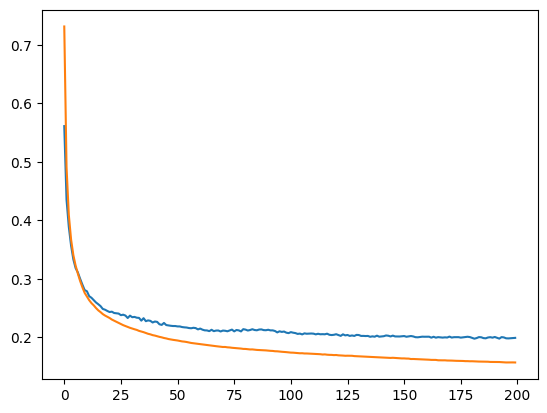

In [107]:
# import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])


In [108]:
y_test_pred = model.predict(X_test_transformed)
y_test_pred_O = np.expm1(y_test_pred)


566/566 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_O))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_O))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_test_pred_O, squared=False))
print("R-squared Score:", r2_score(y_test, y_test_pred_O))


Mean Absolute Error (MAE): 2.5640011322077263
Mean Squared Error (MSE): 31.72170646988698
Root Mean Squared Error (RMSE): 5.632202630400204
R-squared Score: 0.7617963398689331


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_O))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_O))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_test_pred_O, squared=False))
print("R-squared Score:", r2_score(y_test, y_test_pred_O))


Mean Absolute Error (MAE): 2.1947430614580314
Mean Squared Error (MSE): 21.920529268799555
Root Mean Squared Error (RMSE): 4.681936487053147
R-squared Score: 0.8280501995749157


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
X

,latitude,longitude,avg_pm10,avg_pm2,county_encoded,category_encoded,month
0,41.153950,-111.937020,111.263967,110.958733,2,3,9
1,40.639800,-111.822510,141.949592,141.612708,1,4,9
2,41.063160,-111.903320,79.045115,78.739573,3,4,9
3,40.574078,-111.958800,141.949592,141.612708,1,4,9
4,41.066500,-111.912445,79.045115,78.739573,3,4,9
...,...,...,...,...,...,...,...
265671,40.987300,-111.928600,30.669000,27.952500,3,4,1
265672,40.733440,-111.821510,17.150500,15.120600,1,3,1
265673,40.664246,-111.849230,17.150500,15.120600,1,4,1
265674,40.750816,-111.825290,56.609000,43.520000,1,1,1


In [110]:
model.save('../static/data/nnn_model_1_pm_25wind.h5')


In [57]:
y_test_pred_O

array([[ 1.7956142],
       [ 3.5925062],
       [28.04021  ],
       ...,
       [ 1.4853419],
       [ 4.168177 ],
       [ 1.0639913]], dtype=float32)

In [52]:
X_test

,latitude,longitude,avg_pm10,avg_pm2,county_encoded,category_encoded,month
140082,40.785297,-111.863075,87.882076,87.496826,1,4,3
236733,40.696266,-111.877380,28.262254,27.768127,1,2,10
170538,41.118140,-112.031425,62.482979,57.820677,3,1,2
194180,40.686424,-112.018810,41.071299,40.756886,1,3,12
252070,40.691936,-111.991470,188.458205,185.751415,1,2,1
...,...,...,...,...,...,...,...
255933,40.678450,-111.893990,84.995228,78.022272,1,2,1
116423,40.703102,-112.023630,85.823850,85.494863,1,3,4
119824,41.153950,-111.937020,1.399179,1.161071,2,3,4
220288,40.620068,-111.840866,138.224890,137.793809,1,3,10


In [80]:
# Applying log1p transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

25535

In [131]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, X_test.avg_pm2))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, X_test.avg_pm2))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, X_test.avg_pm2, squared=False))
print("R-squared Score:", r2_score(y_test, X_test.avg_pm2))

Mean Absolute Error (MAE): 53.33974102768495
Mean Squared Error (MSE): 6484.495666902835
Root Mean Squared Error (RMSE): 80.52636628398697
R-squared Score: -60.741582211894645


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [132]:
X_test

,latitude,longitude,avg_pm10,avg_pm2,county_encoded,category_encoded,month
72740,40.735943,-111.807720,41.436937,41.041542,1,3,6
261120,41.045660,-111.926216,41.566681,40.656745,3,3,1
181970,40.751663,-111.863530,50.852632,49.713167,1,2,12
126265,40.672577,-111.906160,171.120152,170.413047,1,2,3
197765,40.685400,-111.831660,182.502157,182.271004,1,3,11
...,...,...,...,...,...,...,...
206589,40.785297,-111.863075,180.850496,177.990021,1,4,11
119531,40.677616,-111.834690,79.456239,78.847231,1,4,4
107640,41.195732,-111.936554,1.618400,1.441700,2,3,4
102917,40.665700,-111.821106,5.460698,4.971094,1,4,5


In [ ]:
!

In [93]:
import xgboost as xgb

# Initialize an XGBoost regressor object
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.01,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 100)

# Fit the regressor to the training data
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val_log)],
            early_stopping_rounds=40,
            verbose=True)

# Predict
y_pred = xgb_reg.predict(X_test)


[0]	validation_0-rmse:7.71610
[1]	validation_0-rmse:7.71226
[2]	validation_0-rmse:7.71029
[3]	validation_0-rmse:7.70801
[4]	validation_0-rmse:7.70581
[5]	validation_0-rmse:7.70461
[6]	validation_0-rmse:7.70377
[7]	validation_0-rmse:7.70308
[8]	validation_0-rmse:7.70331
[9]	validation_0-rmse:7.70430
[10]	validation_0-rmse:7.70510
[11]	validation_0-rmse:7.70561
[12]	validation_0-rmse:7.70546
[13]	validation_0-rmse:7.70696
[14]	validation_0-rmse:7.70867


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:7.70935
[16]	validation_0-rmse:7.70961
[17]	validation_0-rmse:7.71018
[18]	validation_0-rmse:7.71288
[19]	validation_0-rmse:7.71491
[20]	validation_0-rmse:7.71805
[21]	validation_0-rmse:7.72062
[22]	validation_0-rmse:7.72352
[23]	validation_0-rmse:7.72805
[24]	validation_0-rmse:7.73184
[25]	validation_0-rmse:7.73614
[26]	validation_0-rmse:7.74099
[27]	validation_0-rmse:7.74662
[28]	validation_0-rmse:7.74903
[29]	validation_0-rmse:7.75472
[30]	validation_0-rmse:7.75638
[31]	validation_0-rmse:7.76054
[32]	validation_0-rmse:7.76749
[33]	validation_0-rmse:7.77448
[34]	validation_0-rmse:7.78207
[35]	validation_0-rmse:7.78739
[36]	validation_0-rmse:7.79222
[37]	validation_0-rmse:7.79984
[38]	validation_0-rmse:7.80831
[39]	validation_0-rmse:7.81507
[40]	validation_0-rmse:7.82341
[41]	validation_0-rmse:7.83233
[42]	validation_0-rmse:7.84174
[43]	validation_0-rmse:7.85156
[44]	validation_0-rmse:7.85795
[45]	validation_0-rmse:7.86298
[46]	validation_0-rmse:7.86656


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 185.47378431983492
Mean Absolute Error: 8.867739388045


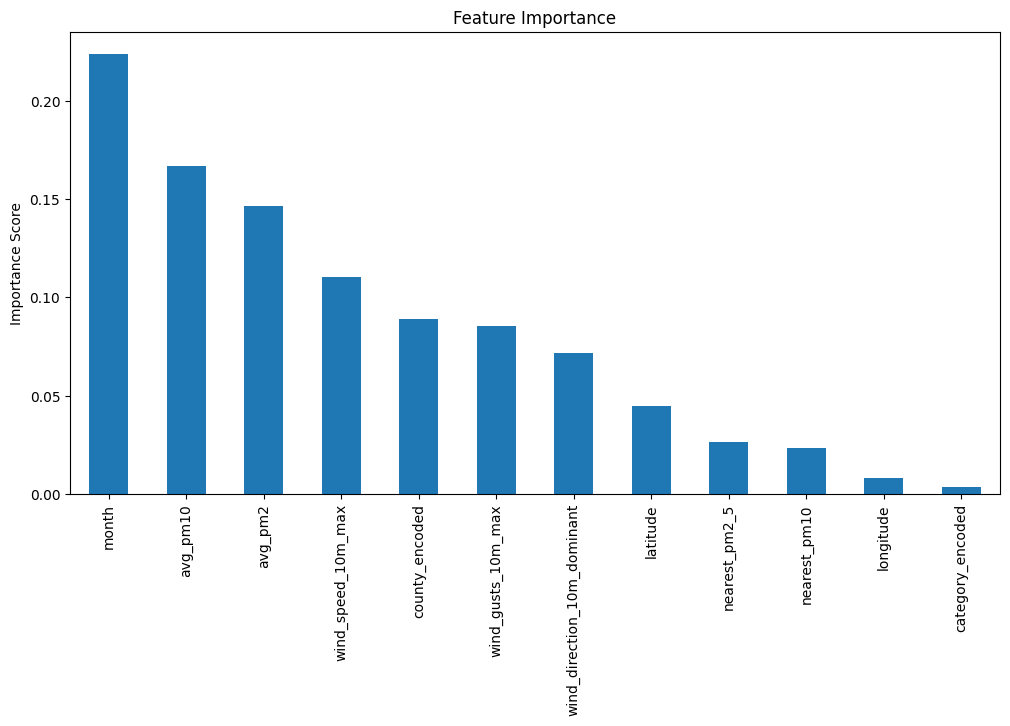

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importances = xgb_reg.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=X_train.columns)

# Plotting
features.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Feature Importance')
plt.ylabel('Importance Score')
plt.show()


In [188]:
import geopandas as gpd
from shapely.geometry import Point
df = joined_gdf_finalx

In [189]:
df.loc[df.date=='2022-09-09']

,sensor_id,latitude,longitude,date,county,category,month,pm2,pm10,avg_pm2,avg_pm10


In [190]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Placeholder for results
nearest_pm2_5 = []

for date, group in df.groupby('date'):
    # Extract coordinates and pm2.5 values
    coords = group[['latitude', 'longitude']].values
    pm2_5_values = group['pm2'].values
    
    # NearestNeighbors model, looking for the 2 closest neighbors
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # The nearest sensor (excluding itself) is at index 1 (0 is the sensor itself)
    nearest_indices = indices[:, 1]
    
    # Retrieve the pm2.5 values of the nearest sensors
    nearest_pm2_5_values = pm2_5_values[nearest_indices]
    
    # Append to our placeholder
    nearest_pm2_5.extend(nearest_pm2_5_values)

# Add the nearest sensor's pm2.5 value as a new column in the original DataFrame
df['nearest_pm2_5'] = nearest_pm2_5


In [185]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.date>='2023-01-01']

In [193]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.pm2<=75]

In [194]:
joined_gdf_finalx

,sensor_id,latitude,longitude,date,county,category,month,pm2,pm10,avg_pm2,avg_pm10,nearest_pm2_5
1432,108126,41.193970,-111.942700,2023-09-07,Weber County,blue,9,1.7515,1.9695,17.405900,17.670467,0.9450
1437,13253,41.088875,-111.964510,2023-09-07,Davis County,green,9,1.6170,1.9415,74.684698,75.021625,8.6840
1438,7466,41.245720,-111.937380,2023-09-07,Weber County,green,9,1.4080,1.6135,17.405900,17.670467,3.0460
1439,6018,41.124454,-111.924706,2023-09-07,Davis County,blue,9,1.7225,1.8845,74.684698,75.021625,0.5390
1441,37499,41.057144,-111.949234,2023-09-07,Davis County,blue,9,1.9045,2.1820,74.684698,75.021625,2.7355
...,...,...,...,...,...,...,...,...,...,...,...,...
265236,30887,40.942867,-111.890440,2023-01-01,Davis County,blue,1,6.5950,8.0045,37.372271,38.302760,4.2445
265237,33077,41.137455,-112.029526,2023-01-01,Davis County,orange,1,2.0555,2.2905,37.372271,38.302760,4.7210
265245,46799,41.087585,-111.978080,2023-01-01,Davis County,green,1,3.3930,3.7080,37.372271,38.302760,3.6135
265246,443,41.224422,-111.968376,2023-01-01,Weber County,red,1,2.9185,3.2925,2.456500,2.792533,9.6760


In [196]:
df = joined_gdf_finalx

In [197]:
df.nearest_pm2_5
df.pm2

print("Mean Absolute Error (MAE):", mean_absolute_error(df.nearest_pm2_5, df.pm2))
print("Mean Squared Error (MSE):", mean_squared_error(df.nearest_pm2_5, df.pm2))
print("Root Mean Squared Error (RMSE):", mean_squared_error(df.nearest_pm2_5, df.pm2, squared=False))
print("R-squared Score:", r2_score(df.nearest_pm2_5, df.pm2))

Mean Absolute Error (MAE): 40.55878279069768
Mean Squared Error (MSE): 53085.54693258907
Root Mean Squared Error (RMSE): 230.40300981668852
R-squared Score: -0.022973315710381303


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [198]:
print("Mean Absolute Error (MAE):", mean_absolute_error(df.avg_pm2, df.pm2))
print("Mean Squared Error (MSE):", mean_squared_error(df.avg_pm2, df.pm2))
print("Root Mean Squared Error (RMSE):", mean_squared_error(df.avg_pm2, df.pm2, squared=False))
print("R-squared Score:", r2_score(df.avg_pm2, df.pm2))

Mean Absolute Error (MAE): 39.4314613705801
Mean Squared Error (MSE): 2358.583267522472
Root Mean Squared Error (RMSE): 48.56524752868528
R-squared Score: -2.0573093891876377


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
